In [6]:
# Necessary Libraries
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, recall_score
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import f1_score 

In [7]:
# Loading CSV data
print("Step 1: Loading CSV data")
exams_df = pd.read_csv('exams.csv')
labels_df = pd.read_csv('samitrop_chagas_labels.csv')

print(f"Exams data: {len(exams_df)} rows")
print(f"Labels data: {len(labels_df)} rows")


Step 1: Loading CSV data
Exams data: 1631 rows
Labels data: 815 rows


In [8]:
# sample data
print("\nExams data sample:")
print(exams_df.head(3))
print("\nLabels data sample:")
print(labels_df.head(3))


Exams data sample:
   exam_id  age  is_male  normal_ecg  death     timey  nn_predicted_age
0   294669   67     True       False  False  2.116020         51.093110
1   291318   65     True       False  False  3.077345         76.923935
2   247007   67    False       False  False  2.378450         61.212074

Labels data sample:
   exam_id  chagas
0   247007    True
1   181629    True
2   406936    True


In [9]:
# Set all exams as negative by default
exams_df['chagas'] = 0

# Update the chagas labels for the 815 IDs in labels_df to be positive
exams_df.loc[exams_df['exam_id'].isin(labels_df['exam_id']), 'chagas'] = 1


merged_df = exams_df
print(f"\nTotal records: {len(merged_df)}")


Total records: 1631


In [10]:
# Check class balance
chagas_count = merged_df['chagas'].sum()
print(f"Chagas positive: {chagas_count} ({chagas_count/len(merged_df)*100:.2f}%)")
print(f"Chagas negative: {len(merged_df) - chagas_count} ({(1-chagas_count/len(merged_df))*100:.2f}%)")


Chagas positive: 815 (49.97%)
Chagas negative: 816 (50.03%)


In [11]:
# Loading ECG data from HDF5 file
print("\nStep 2: Loading ECG data from HDF5 file")

if not os.path.exists('exams.hdf5'):
    raise FileNotFoundError("The file 'exams.hdf5' was not found in the current directory.")

# Open HDF5 file
with h5py.File('exams.hdf5', 'r') as hdf:
    # Print the structure of the HDF5 file
    print("HDF5 file structure:")
    for key in hdf.keys():
        print(f"Key: {key}")
        if isinstance(hdf[key], h5py.Group):
            print(f"  Type: Group")
            for subkey in hdf[key].keys():
                print(f"  Subkey: {subkey}")
        else:
            print(f"  Type: Dataset")
            print(f"  Shape: {hdf[key].shape}")
    
    # Since HDF5 has a 'tracings' key
    if 'tracings' in hdf:
        print("\nAccessing 'tracings' dataset")
        tracings = hdf['tracings']
        print(f"Tracings shape: {tracings.shape}")
        
        # Checking if there's an 'exam_id' dataset that maps indices to exam_ids
        if 'exam_id' in hdf:
            # If there's a mapping between indices and exam_ids
            exam_id_mapping = hdf['exam_id'][:]
            print(f"Found exam_id mapping with {len(exam_id_mapping)} entries")
        else:
            # If there's no explicit mapping, we'll need to determine how tracings map to exam_ids
            print("No explicit exam_id mapping found. Assuming sequential ordering.")
            # Here we're assuming that the order of tracings corresponds to the order of exam_ids in the CSV
            exam_id_mapping = merged_df['exam_id'].values
            if len(exam_id_mapping) != tracings.shape[0]:
                print(f"Warning: Number of tracings ({tracings.shape[0]}) doesn't match number of exam_ids ({len(exam_id_mapping)})")
                # Use the minimum number to avoid index errors
                min_length = min(len(exam_id_mapping), tracings.shape[0])
                exam_id_mapping = exam_id_mapping[:min_length]
                print(f"Using first {min_length} exam_ids for mapping")
        
        # Initialize lists to store ECG data and labels
        ecg_data = []
        labels = []
        original_ids = []
        
        # Load ECG data for each exam
        print("\nLoading ECG data...")
        for i in range(len(exam_id_mapping)):
            if i % 100 == 0:
                print(f"  Progress: {i}/{len(exam_id_mapping)} ECGs loaded")
            
            # Get the exam_id for this tracing
            exam_id = exam_id_mapping[i]
            
            # Get the label from our merged dataframe
            label_row = merged_df.loc[merged_df['exam_id'] == exam_id]
            if len(label_row) == 0:
                print(f"  Warning: No label found for ID {exam_id}. Skipping.")
                continue
            
            label = label_row['chagas'].values[0]
            
            try:
                # Get the ECG data
                ecg = tracings[i]
                
                # Check and fix shape if needed
                if len(ecg.shape) == 1:
                    # If it's one-dimensional, reshape it
                    print(f"  Single-dimension ECG found with shape {ecg.shape}. Reshaping...")
                    # Assume it's 12 leads concatenated
                    n_samples = ecg.shape[0] // 12
                    ecg = ecg.reshape(n_samples, 12)
                
                # Print shape info for the first ECG
                if i == 0:
                    print(f"  First ECG shape: {ecg.shape}")
                    # If shape is (12, time_points) instead of (time_points, 12), transpose it
                    if ecg.shape[1] != 12 and ecg.shape[0] == 12:
                        print("  Transposing ECG data to get (time_points, leads) format")
                        ecg = ecg.T
                        print(f"  Transposed shape: {ecg.shape}")
                
                # Add to lists
                ecg_data.append(ecg)
                labels.append(label)
                original_ids.append(exam_id)
            except Exception as e:
                print(f"  Error loading ECG for ID {exam_id}: {e}")
                continue
    else:
        raise ValueError("Expected 'tracings' dataset not found in HDF5 file")



Step 2: Loading ECG data from HDF5 file
HDF5 file structure:
Key: tracings
  Type: Dataset
  Shape: (1631, 4096, 12)

Accessing 'tracings' dataset
Tracings shape: (1631, 4096, 12)
No explicit exam_id mapping found. Assuming sequential ordering.

Loading ECG data...
  Progress: 0/1631 ECGs loaded
  First ECG shape: (4096, 12)
  Progress: 100/1631 ECGs loaded
  Progress: 200/1631 ECGs loaded
  Progress: 300/1631 ECGs loaded
  Progress: 400/1631 ECGs loaded
  Progress: 500/1631 ECGs loaded
  Progress: 600/1631 ECGs loaded
  Progress: 700/1631 ECGs loaded
  Progress: 800/1631 ECGs loaded
  Progress: 900/1631 ECGs loaded
  Progress: 1000/1631 ECGs loaded
  Progress: 1100/1631 ECGs loaded
  Progress: 1200/1631 ECGs loaded
  Progress: 1300/1631 ECGs loaded
  Progress: 1400/1631 ECGs loaded
  Progress: 1500/1631 ECGs loaded
  Progress: 1600/1631 ECGs loaded


In [12]:

# Check if we loaded any data
if len(ecg_data) == 0:
    raise ValueError("No ECG data was successfully loaded. Cannot proceed.")

print(f"Successfully loaded {len(ecg_data)} ECGs")

# Check if ECGs have consistent shapes
shapes = [ecg.shape for ecg in ecg_data]
unique_shapes = set(shapes)
if len(unique_shapes) > 1:
    print(f"Warning: Inconsistent ECG shapes detected. Found {len(unique_shapes)} different shapes.")
    
    # Finding the most common shape
    most_common_shape = max(unique_shapes, key=shapes.count)
    print(f"Using most common shape: {most_common_shape}")
    
    # Filter to keep only ECGs with the most common shape
    filtered_data = []
    filtered_labels = []
    filtered_ids = []
    for i in range(len(ecg_data)):
        if ecg_data[i].shape == most_common_shape:
            filtered_data.append(ecg_data[i])
            filtered_labels.append(labels[i])
            filtered_ids.append(original_ids[i])
    
    ecg_data = filtered_data
    labels = filtered_labels
    original_ids = filtered_ids
    print(f"After filtering: {len(ecg_data)} ECGs with consistent shape")

# Create numpy arrays for model training
# Ensure all ECGs have the same length
if len(ecg_data) > 0:
    time_points = max(ecg.shape[0] for ecg in ecg_data)
    n_leads = ecg_data[0].shape[1]  # Typically 12 for standard ECG
    
    X = np.zeros((len(ecg_data), time_points, n_leads))
    for i, ecg in enumerate(ecg_data):
        # Pad or truncate to the same length
        if ecg.shape[0] < time_points:
            # Pad with zeros
            X[i, :ecg.shape[0], :] = ecg
        else:
            # Truncate
            X[i, :, :] = ecg[:time_points, :]
            
    y = np.array(labels)
    
    print(f"Final ECG data shape: {X.shape}")
    print(f"Labels shape: {y.shape}")

Successfully loaded 1631 ECGs
Final ECG data shape: (1631, 4096, 12)
Labels shape: (1631,)


In [13]:
# Preprocess ECG data
print("\nStep 3: Preprocessing ECG data")

# Split data into training and testing sets
X_indices = np.arange(len(X))
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X, y, X_indices, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Normalize each ECG to have zero mean and unit variance
for i in range(X_train.shape[0]):
    for lead in range(X_train.shape[2]):
        # Avoid division by zero
        std = np.std(X_train[i, :, lead])
        if std == 0:
            X_train[i, :, lead] = 0
        else:
            X_train[i, :, lead] = (X_train[i, :, lead] - np.mean(X_train[i, :, lead])) / std

for i in range(X_test.shape[0]):
    for lead in range(X_test.shape[2]):
        # Avoid division by zero
        std = np.std(X_test[i, :, lead])
        if std == 0:
            X_test[i, :, lead] = 0
        else:
            X_test[i, :, lead] = (X_test[i, :, lead] - np.mean(X_test[i, :, lead])) / std



Step 3: Preprocessing ECG data
Training set size: (1304, 4096, 12)
Testing set size: (327, 4096, 12)


In [13]:
#  Visualize sample ECGs
print("\nStep 4: Visualizing sample ECGs")

# Get indices of Chagas positive and negative samples
pos_indices = np.where(y == 1)[0]
neg_indices = np.where(y == 0)[0]

# Check if we have samples of both classes
if len(pos_indices) > 0 and len(neg_indices) > 0:
    # Number of samples to visualize
    n_samples = 2
    
    # Plot Chagas positive and negative samples
    plt.figure(figsize=(15, 10))
    
    # Plot Chagas positive samples
    for i in range(min(n_samples, len(pos_indices))):
        idx = pos_indices[i]
        plt.subplot(2, n_samples, i+1)
        
        # Plot all leads
        for lead in range(X.shape[2]):
            plt.plot(X[idx, :, lead], alpha=0.7, linewidth=0.5)
        
        plt.title(f"Chagas Positive (ID: {original_ids[idx]})")
        plt.ylim(-5, 5)
    
    # Plot Chagas negative samples
    for i in range(min(n_samples, len(neg_indices))):
        idx = neg_indices[i]
        plt.subplot(2, n_samples, i+n_samples+1)
        
        # Plot all leads
        for lead in range(X.shape[2]):
            plt.plot(X[idx, :, lead], alpha=0.7, linewidth=0.5)
        
        plt.title(f"Chagas Negative (ID: {original_ids[idx]})")
        plt.ylim(-5, 5)
    
    plt.tight_layout()
    plt.savefig('sample_ecgs.png')
    plt.close()
    print("Sample ECGs saved to 'sample_ecgs.png'")
else:
    print("Cannot visualize: missing examples from one or both classes")



Step 4: Visualizing sample ECGs
Sample ECGs saved to 'sample_ecgs.png'


In [14]:
# PyTorch Dataset and DataLoader
print("\nStep 5: Creating PyTorch Dataset and DataLoader")

# Define a custom Dataset class
class ECGDataset(Dataset):
    def __init__(self, ecg_data, labels):
        self.ecg_data = torch.tensor(ecg_data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
        
    def __len__(self):
        return len(self.ecg_data)
    
    def __getitem__(self, idx):
        ecg = self.ecg_data[idx]
        label = self.labels[idx]
        return ecg, label

# Create datasets
train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Created train_loader with {len(train_loader)} batches of size {batch_size}")
print(f"Created test_loader with {len(test_loader)} batches of size {batch_size}")



Step 5: Creating PyTorch Dataset and DataLoader
Created train_loader with 82 batches of size 16
Created test_loader with 21 batches of size 16


### Random Search CV (Interrupted due to Processing Issues)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
import random
import time
import matplotlib.pyplot as plt

# Define a 1D CNN model with configurable hyperparameters
class ECG_CNN_1D(nn.Module):
    def __init__(self, input_channels=12, conv_filters=64, kernel_size=5, 
                 pool_size=2, dropout_rate=0.5, fc_units=64):
        super(ECG_CNN_1D, self).__init__()
        
        # Single convolutional block
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=conv_filters, 
                              kernel_size=kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(conv_filters)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=pool_size)
        
        # Calculate the size of flattened features
        # For time series of length L, after pooling with kernel_size=pool_size, it becomes L/pool_size
        self.flattened_size = (time_points // pool_size) * conv_filters
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, fc_units)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(fc_units, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # PyTorch Conv1d expects input shape (batch_size, channels, seq_length)
        x = x.permute(0, 2, 1)
        
        # Convolutional block
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.dropout(self.relu2(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        
        return x

# Function to train and evaluate a model with specific hyperparameters
def train_evaluate_model(train_dataset, val_dataset, hp, num_epochs=10, early_stopping_patience=3):
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=hp['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=hp['batch_size'], shuffle=False)
    
    # Create model with current hyperparameters
    model = ECG_CNN_1D(
        input_channels=n_leads,
        conv_filters=hp['conv_filters'],
        kernel_size=hp['kernel_size'],
        pool_size=hp['pool_size'],
        dropout_rate=hp['dropout_rate'],
        fc_units=hp['fc_units']
    )
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=hp['learning_rate'], weight_decay=hp['weight_decay'])
    
    # Training loop with early stopping
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_true = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Track statistics
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                # Store predictions and true labels
                val_preds.extend(outputs.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
        
        # Calculate validation statistics
        val_epoch_loss = val_loss / len(val_dataset)
        val_epoch_acc = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)
        
        # Check for early stopping
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping triggered after epoch {epoch+1}")
                break
    
    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Final evaluation
    model.eval()
    val_preds = []
    val_true = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_preds.extend(outputs.cpu().numpy())
            val_true.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    val_preds = np.array(val_preds).flatten()
    val_true = np.array(val_true).flatten()
    
    # Calculate final metrics
    val_pred_class = (val_preds > 0.5).astype(float)
    accuracy = accuracy_score(val_true, val_pred_class)
    try:
        auc = roc_auc_score(val_true, val_preds)
    except:
        auc = 0.5  # Default value if calculation fails
    
    return {
        'val_loss': best_val_loss,
        'accuracy': accuracy,
        'auc': auc,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'model_state': best_model_state
    }

# Define hyperparameter search space
param_grid = {
    'learning_rate': [0.01, 0.005, 0.001, 0.0005, 0.0001],
    'batch_size': [8, 16, 32, 64],
    'dropout_rate': [0.3, 0.4, 0.5, 0.6],
    'conv_filters': [32, 64, 128, 256],
    'kernel_size': [3, 5, 7, 9],
    'pool_size': [2, 4],
    'fc_units': [32, 64, 128],
    'weight_decay': [0, 1e-5, 1e-4, 1e-3]
}

# Function to perform random search
def random_search(param_grid, train_dataset, val_dataset, n_trials=20, epochs=15):
    results = []
    best_score = 0
    best_params = None
    best_model_state = None
    
    print(f"Starting random search with {n_trials} trials...")
    
    for i in range(n_trials):
        # Randomly select hyperparameters
        hp = {
            'learning_rate': random.choice(param_grid['learning_rate']),
            'batch_size': random.choice(param_grid['batch_size']),
            'dropout_rate': random.choice(param_grid['dropout_rate']),
            'conv_filters': random.choice(param_grid['conv_filters']),
            'kernel_size': random.choice(param_grid['kernel_size']),
            'pool_size': random.choice(param_grid['pool_size']),
            'fc_units': random.choice(param_grid['fc_units']),
            'weight_decay': random.choice(param_grid['weight_decay'])
        }
        
        print(f"\nTrial {i+1}/{n_trials} - Testing parameters:")
        for k, v in hp.items():
            print(f"  {k}: {v}")
        
        # Train and evaluate model
        start_time = time.time()
        result = train_evaluate_model(train_dataset, val_dataset, hp, num_epochs=epochs)
        elapsed_time = time.time() - start_time
        
        # Store results
        result['hyperparameters'] = hp
        result['trial'] = i + 1
        result['time'] = elapsed_time
        results.append(result)
        
        print(f"Completed in {elapsed_time:.2f}s - Accuracy: {result['accuracy']:.4f}, AUC: {result['auc']:.4f}")
        
        # Track best model
        if result['accuracy'] > best_score:
            best_score = result['accuracy']
            best_params = hp
            best_model_state = result['model_state']
            print(f"New best model found!")
        
    return results, best_params, best_model_state

# Execute the random search
# Reuse existing train_dataset and test_dataset from your earlier code
results, best_params, best_model_state = random_search(param_grid, train_dataset, test_dataset, n_trials=15, epochs=10)

# Print the best parameters
print("\nBest Hyperparameters Found:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# Visualize results
plt.figure(figsize=(12, 8))
accuracies = [r['accuracy'] for r in results]
aucs = [r['auc'] for r in results]
trials = [r['trial'] for r in results]

plt.subplot(2, 1, 1)
plt.bar(trials, accuracies)
plt.axhline(y=max(accuracies), color='r', linestyle='-', alpha=0.3)
plt.title('Accuracy by Trial')
plt.xlabel('Trial')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.bar(trials, aucs)
plt.axhline(y=max(aucs), color='r', linestyle='-', alpha=0.3)
plt.title('AUC by Trial')
plt.xlabel('Trial')
plt.ylabel('AUC')

plt.tight_layout()
plt.savefig('hyperparameter_tuning_results.png')
plt.close()

# Create and train the final model with the best parameters
final_model = ECG_CNN_1D(
    input_channels=n_leads,
    conv_filters=best_params['conv_filters'],
    kernel_size=best_params['kernel_size'],
    pool_size=best_params['pool_size'],
    dropout_rate=best_params['dropout_rate'],
    fc_units=best_params['fc_units']
)
final_model = final_model.to(device)
final_model.load_state_dict(best_model_state)

# Evaluate the final model
final_model.eval()
all_preds = []
all_preds_prob = []
all_labels = []

test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        
        preds_prob = outputs.cpu().numpy()
        preds = (outputs > 0.5).float().cpu().numpy()
        labels = labels.cpu().numpy()
        
        all_preds.extend(preds)
        all_preds_prob.extend(preds_prob)
        all_labels.extend(labels)

all_preds = np.array(all_preds).flatten()
all_preds_prob = np.array(all_preds_prob).flatten()
all_labels = np.array(all_labels).flatten()

# Print final evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("\nFinal Model Evaluation:")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# Plot ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_preds_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Model')
plt.legend(loc="lower right")
plt.savefig('best_model_roc.png')
plt.close()

# Save the best model
torch.save(final_model.state_dict(), 'best_chagas_detection_model.pth')

Starting random search with 15 trials...

Trial 1/15 - Testing parameters:
  learning_rate: 0.005
  batch_size: 64
  dropout_rate: 0.6
  conv_filters: 256
  kernel_size: 7
  pool_size: 2
  fc_units: 128
  weight_decay: 1e-05
Early stopping triggered after epoch 5
Completed in 467.45s - Accuracy: 0.4985, AUC: 0.5000
New best model found!

Trial 2/15 - Testing parameters:
  learning_rate: 0.0005
  batch_size: 32
  dropout_rate: 0.6
  conv_filters: 32
  kernel_size: 5
  pool_size: 2
  fc_units: 64
  weight_decay: 0.0001
Early stopping triggered after epoch 7
Completed in 57.51s - Accuracy: 0.5046, AUC: 0.5083
New best model found!

Trial 3/15 - Testing parameters:
  learning_rate: 0.0005
  batch_size: 8
  dropout_rate: 0.4
  conv_filters: 32
  kernel_size: 3
  pool_size: 2
  fc_units: 64
  weight_decay: 0.001
Early stopping triggered after epoch 4
Completed in 57.71s - Accuracy: 0.5046, AUC: 0.5149

Trial 4/15 - Testing parameters:
  learning_rate: 0.005
  batch_size: 8
  dropout_rate: 0.

KeyboardInterrupt: 

### Bayesian Optimization 

Preprocessing ECG data...
Processed data shape: (1304, 512, 12)
Starting Bayesian hyperparameter tuning...
Dataset stats: 652 positive samples, 652 negative samples
Using positive class weight: 1.0000

Starting Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Using BCEWithLogitsLoss with positive class weight: 1.0000
Error during training: stack expects each tensor to be equal size, but got [512, 12] at entry 0 and [20, 12] at entry 8
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1112
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 2 started. Evaluating function at random point.
Using BCEWithLogitsLoss with positive class weight: 1.0000
Error during training: The size of tensor a (129) must match the size of tensor b (128) at non-singleton dimension 2
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0610
Function value obtained: 0.0000
Current minimum: 0.0000
Iteratio

C:\Users\rjhha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using BCEWithLogitsLoss with positive class weight: 1.0000
Error during training: stack expects each tensor to be equal size, but got [16, 12] at entry 0 and [512, 12] at entry 1
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0495
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 4 started. Evaluating function at random point.
Using BCEWithLogitsLoss with positive class weight: 1.0000
Error during training: stack expects each tensor to be equal size, but got [512, 12] at entry 0 and [2, 12] at entry 2
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0588
Function value obtained: 0.0000
Current minimum: 0.0000
Iteration No: 5 started. Evaluating function at random point.
Using BCEWithLogitsLoss with positive class weight: 1.0000
Epoch 1/8, Train Loss: 0.7247, Val F1: 0.6653 (thresh=0.20), AUROC: 0.5077
Epoch 2/8, Train Loss: 0.7064, Val F1: 0.6653 (thresh=0.20), AUROC: 0.5218
Epoch 3/8, Train Loss: 0.7050, Val F1: 0.6653 (t

C:\Users\rjhha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/8, Train Loss: 1.8023, Val F1: 0.6653 (thresh=0.20), AUROC: 0.5066
Epoch 2/8, Train Loss: 0.7023, Val F1: 0.6653 (thresh=0.20), AUROC: 0.5232
Epoch 3/8, Train Loss: 0.6935, Val F1: 0.6653 (thresh=0.20), AUROC: 0.5100
Epoch 4/8, Train Loss: 0.6949, Val F1: 0.6653 (thresh=0.20), AUROC: 0.4999
Early stopping triggered after epoch 4
Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 27.6427
Function value obtained: -0.6653
Current minimum: -0.6653
Iteration No: 7 started. Searching for the next optimal point.
Using BCEWithLogitsLoss with positive class weight: 1.0000


C:\Users\rjhha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/8, Train Loss: 0.8754, Val F1: 0.6667 (thresh=0.50), AUROC: 0.4704
Epoch 2/8, Train Loss: 0.7364, Val F1: 0.6653 (thresh=0.20), AUROC: 0.5193
Epoch 3/8, Train Loss: 0.7095, Val F1: 0.6653 (thresh=0.20), AUROC: 0.4906
Epoch 4/8, Train Loss: 0.7028, Val F1: 0.6653 (thresh=0.20), AUROC: 0.4838
Early stopping triggered after epoch 4
Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 4.8480
Function value obtained: -0.6667
Current minimum: -0.6667
Iteration No: 8 started. Searching for the next optimal point.
Using BCEWithLogitsLoss with positive class weight: 1.0000


C:\Users\rjhha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/8, Train Loss: 0.8071, Val F1: 0.6653 (thresh=0.20), AUROC: 0.4293
Epoch 2/8, Train Loss: 0.7125, Val F1: 0.6653 (thresh=0.20), AUROC: 0.4985
Epoch 3/8, Train Loss: 0.7021, Val F1: 0.6653 (thresh=0.20), AUROC: 0.5039
Epoch 4/8, Train Loss: 0.6939, Val F1: 0.6653 (thresh=0.20), AUROC: 0.5204
Early stopping triggered after epoch 4
Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 32.0300
Function value obtained: -0.6653
Current minimum: -0.6667
Iteration No: 9 started. Searching for the next optimal point.
Using BCEWithLogitsLoss with positive class weight: 1.0000


C:\Users\rjhha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/8, Train Loss: 0.7840, Val F1: 0.6653 (thresh=0.20), AUROC: 0.4978
Epoch 2/8, Train Loss: 0.7227, Val F1: 0.6653 (thresh=0.20), AUROC: 0.4695
Epoch 3/8, Train Loss: 0.7199, Val F1: 0.6653 (thresh=0.20), AUROC: 0.4532
Epoch 4/8, Train Loss: 0.7187, Val F1: 0.6667 (thresh=0.50), AUROC: 0.4499
Epoch 5/8, Train Loss: 0.7118, Val F1: 0.6653 (thresh=0.20), AUROC: 0.4550
Epoch 6/8, Train Loss: 0.7029, Val F1: 0.6653 (thresh=0.20), AUROC: 0.4607
Epoch 7/8, Train Loss: 0.7063, Val F1: 0.6653 (thresh=0.20), AUROC: 0.4662
Early stopping triggered after epoch 7
Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 8.9837
Function value obtained: -0.6667
Current minimum: -0.6667
Iteration No: 10 started. Searching for the next optimal point.
Using BCEWithLogitsLoss with positive class weight: 1.0000


C:\Users\rjhha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/8, Train Loss: 0.7113, Val F1: 0.6653 (thresh=0.20), AUROC: 0.4730
Epoch 2/8, Train Loss: 0.7116, Val F1: 0.6653 (thresh=0.20), AUROC: 0.5014
Epoch 3/8, Train Loss: 0.7087, Val F1: 0.6653 (thresh=0.20), AUROC: 0.5058
Epoch 4/8, Train Loss: 0.7114, Val F1: 0.6653 (thresh=0.20), AUROC: 0.5121
Early stopping triggered after epoch 4
Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 5.9850
Function value obtained: -0.6653
Current minimum: -0.6667

Bayesian optimization completed.
Best parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'conv_filters': 32, 'kernel_size': 3, 'dropout_rate': 0.33062696549499115, 'weight_decay': 1e-05, 'use_batch_norm': np.False_, 'use_augmentation': np.False_}
Best validation F1-score: 0.6667

Training final model with best parameters...
Using BCEWithLogitsLoss with positive class weight: 1.0000


C:\Users\rjhha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20, Train Loss: 0.7536, Val F1: 0.6653 (thresh=0.20), AUROC: 0.5084
Epoch 2/20, Train Loss: 0.7271, Val F1: 0.6653 (thresh=0.20), AUROC: 0.5119
Epoch 3/20, Train Loss: 0.7136, Val F1: 0.6653 (thresh=0.20), AUROC: 0.5146
Epoch 4/20, Train Loss: 0.7107, Val F1: 0.6653 (thresh=0.20), AUROC: 0.5198
Epoch 5/20, Train Loss: 0.7101, Val F1: 0.6653 (thresh=0.20), AUROC: 0.5193
Epoch 6/20, Train Loss: 0.7021, Val F1: 0.6653 (thresh=0.20), AUROC: 0.5205
Early stopping triggered after epoch 6

Final Model Evaluation:
Using classification threshold: 0.2000

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       164
         1.0       0.50      1.00      0.67       163

    accuracy                           0.50       327
   macro avg       0.25      0.50      0.33       327
weighted avg       0.25      0.50      0.33       327


Confusion Matrix:
[[  0 164]
 [  0 163]]

Additional Metrics:
Accuracy: 0.4985
Sensitivit

C:\Users\rjhha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rjhha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rjhha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

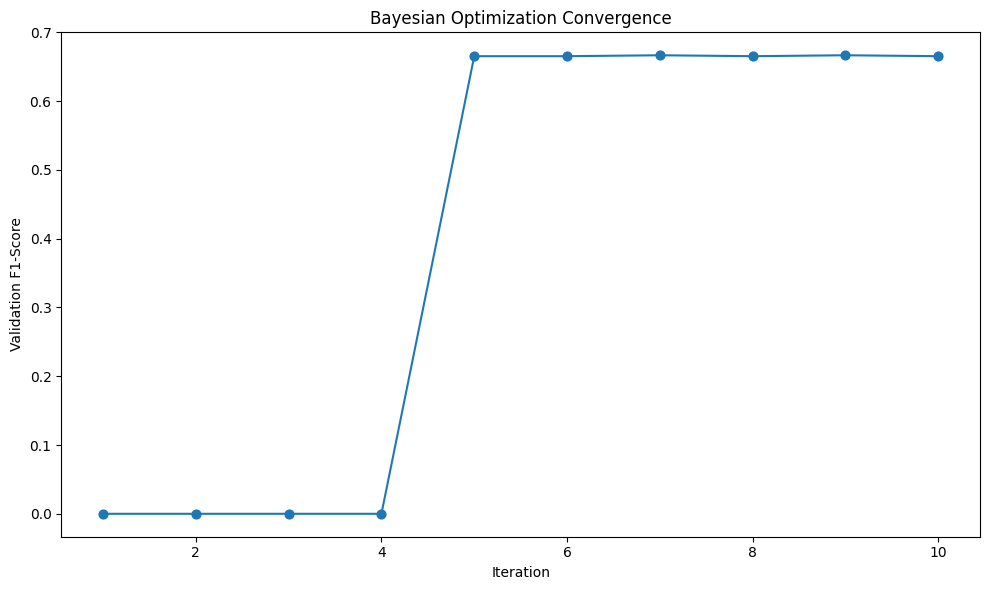

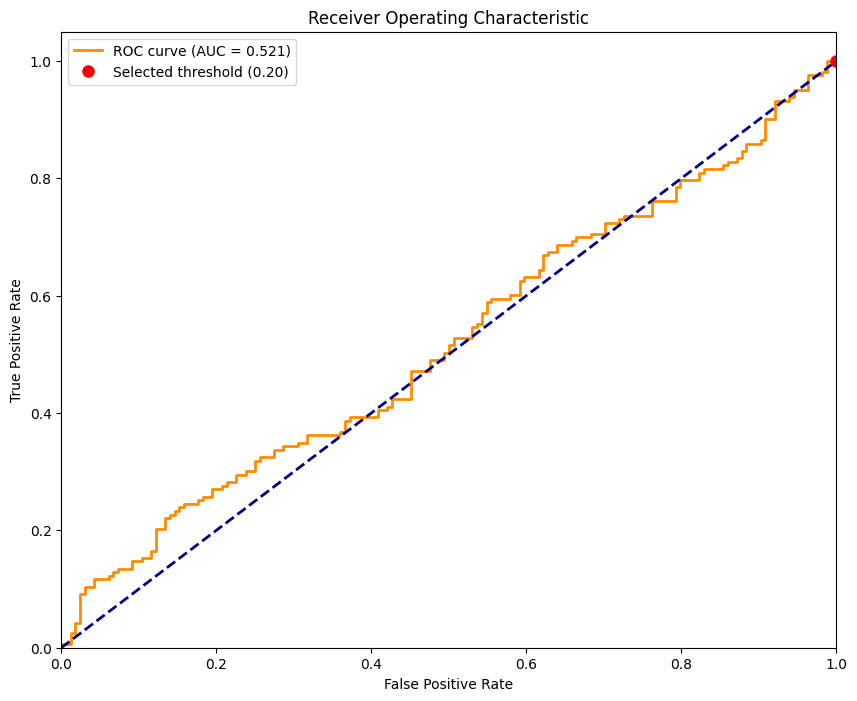

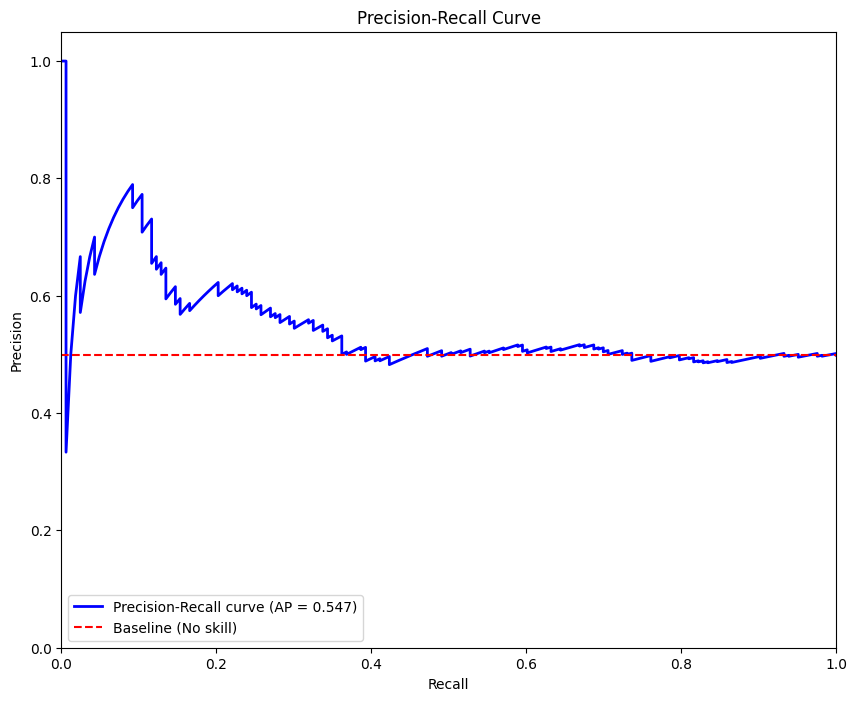

In [ ]:
"""
ECG-based Chagas Disease Detection using Bayesian Optimization for Hyperparameter Tuning
"""

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

#########################
# DATA PREPROCESSING
#########################

def preprocess_ecg(X, downsample_factor=8, normalize=True):
    """
    Simple but robust preprocessing for ECG signals
    """
    # Downsample to reduce computation
    X_down = X[:, ::downsample_factor, :]
    
    # Normalize each signal to have zero mean and unit variance
    if normalize:
        for i in range(X_down.shape[0]):
            for j in range(X_down.shape[2]):
                mean = np.mean(X_down[i, :, j])
                std = np.std(X_down[i, :, j])
                if std > 0:
                    X_down[i, :, j] = (X_down[i, :, j] - mean) / std
    
    return X_down

#########################
# DATASET CLASS
#########################

class ECGDataset(torch.utils.data.Dataset):
    """
    Custom PyTorch dataset for ECG data
    """
    def __init__(self, ecg_data, labels, augment=False):
        self.ecg_data = torch.tensor(ecg_data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
        self.augment = augment
        
    def __len__(self):
        return len(self.ecg_data)
    
    def __getitem__(self, idx):
        ecg = self.ecg_data[idx]
        label = self.labels[idx]
        
        # Apply data augmentation if enabled
        if self.augment and np.random.random() < 0.5:
            # Random scaling
            scale_factor = 0.9 + 0.2 * np.random.random()
            ecg = ecg * scale_factor
            
            # Random noise addition
            noise_level = 0.05 * np.random.random()
            noise = torch.randn_like(ecg) * noise_level
            ecg = ecg + noise
            
            # Random time shift (shift the signal in time)
            if ecg.shape[0] > 20:  # Only if signal is long enough
                shift = np.random.randint(-10, 10)
                if shift > 0:
                    ecg = torch.cat([ecg[shift:], torch.zeros_like(ecg[:shift])], dim=0)
                elif shift < 0:
                    ecg = torch.cat([torch.zeros_like(ecg[:-shift]), ecg[:-shift]], dim=0)
        
        return ecg, label

#########################
# MODEL ARCHITECTURE
#########################

class ImprovedECGModel(nn.Module):
    """
    Improved 1D CNN model for ECG classification with a focus on balanced learning
    """
    def __init__(self, input_channels=12, conv_filters=64, kernel_size=5, 
                 dropout_rate=0.5, use_batch_norm=True):
        super(ImprovedECGModel, self).__init__()
        
        self.use_batch_norm = use_batch_norm
        
        # Initial conv layer with smaller number of filters
        self.conv1 = nn.Conv1d(input_channels, conv_filters//2, kernel_size, padding=kernel_size//2)
        if use_batch_norm:
            self.bn1 = nn.BatchNorm1d(conv_filters//2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        # Second conv layer
        self.conv2 = nn.Conv1d(conv_filters//2, conv_filters, kernel_size, padding=kernel_size//2)
        if use_batch_norm:
            self.bn2 = nn.BatchNorm1d(conv_filters)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Third conv layer with residual connection
        self.conv3 = nn.Conv1d(conv_filters, conv_filters, kernel_size, padding=kernel_size//2)
        if use_batch_norm:
            self.bn3 = nn.BatchNorm1d(conv_filters)
        self.relu3 = nn.ReLU()
        
        # Fourth conv layer
        self.conv4 = nn.Conv1d(conv_filters, conv_filters*2, kernel_size, padding=kernel_size//2)
        if use_batch_norm:
            self.bn4 = nn.BatchNorm1d(conv_filters*2)
        self.relu4 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Global pooling layer
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(conv_filters*2, 128)
        self.relu5 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.relu6 = nn.ReLU()
        self.dropout4 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 1)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Format for Conv1d: [batch, channels, seq_len]
        x = x.permute(0, 2, 1)
        
        # First convolutional block
        if self.use_batch_norm:
            x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
            x = self.pool2(self.dropout1(self.relu2(self.bn2(self.conv2(x)))))
            
            # Residual connection
            residual = x
            x = self.relu3(self.bn3(self.conv3(x)))
            x = x + residual  # Add residual connection
            
            x = self.pool3(self.dropout2(self.relu4(self.bn4(self.conv4(x)))))
        else:
            x = self.pool1(self.relu1(self.conv1(x)))
            x = self.pool2(self.dropout1(self.relu2(self.conv2(x))))
            
            # Residual connection
            residual = x
            x = self.relu3(self.conv3(x))
            x = x + residual  # Add residual connection
            
            x = self.pool3(self.dropout2(self.relu4(self.conv4(x))))
        
        # Global pooling
        x = self.global_pool(x).squeeze(-1)
        
        # Fully connected layers
        x = self.dropout3(self.relu5(self.fc1(x)))
        x = self.dropout4(self.relu6(self.fc2(x)))
        x = self.fc3(x)
        
        # No sigmoid activation - use with BCEWithLogitsLoss
        return x

#########################
# TRAINING & EVALUATION
#########################

def train_and_evaluate_model(model, train_loader, val_loader, lr, weight_decay, 
                            pos_weight=1.0, epochs=10, patience=3):
    """
    Train and evaluate a model with early stopping and balanced loss function
    """
    # Initialize optimizer with a more aggressive weight decay
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=True)
    
    # Use BCEWithLogitsLoss which combines sigmoid and BCE - more numerically stable
    # Apply class weighting to handle imbalance
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))
    print(f"Using BCEWithLogitsLoss with positive class weight: {pos_weight:.4f}")
    
    # Early stopping setup - track F1 score
    best_val_f1 = 0
    patience_counter = 0
    best_model_state = None
    best_threshold = 0.5
    
    train_losses = []
    val_f1_scores = []
    val_auroc_scores = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_outputs = []
        val_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_outputs.extend(outputs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_outputs = np.array(val_outputs).flatten()
        val_labels = np.array(val_labels).flatten()
        
        # Apply sigmoid to get probabilities
        val_probs = 1 / (1 + np.exp(-val_outputs))
        
        # Find optimal threshold using validation data
        thresholds = np.arange(0.2, 0.8, 0.05)
        current_best_f1 = 0
        current_best_threshold = 0.5
        
        for threshold in thresholds:
            val_preds = (val_probs > threshold).astype(float)
            f1 = f1_score(val_labels, val_preds)
            if f1 > current_best_f1:
                current_best_f1 = f1
                current_best_threshold = threshold
        
        # Make predictions with best threshold
        val_preds = (val_probs > current_best_threshold).astype(float)
        val_f1 = f1_score(val_labels, val_preds)
        
        # Calculate AUROC score
        fpr, tpr, _ = roc_curve(val_labels, val_probs)
        auroc = auc(fpr, tpr)
        
        val_f1_scores.append(val_f1)
        val_auroc_scores.append(auroc)
        
        # Update learning rate based on F1 score (maximize)
        scheduler.step(val_f1)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, "
              f"Val F1: {val_f1:.4f} (thresh={current_best_threshold:.2f}), AUROC: {auroc:.4f}")
        
        # Early stopping based on F1 score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_threshold = current_best_threshold
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after epoch {epoch+1}")
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Plot training progress
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(val_f1_scores, label='F1 Score')
    plt.plot(val_auroc_scores, label='AUROC')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_progress.png')
    plt.close()
    
    return model, best_val_f1, best_threshold

#########################
# BAYESIAN OPTIMIZATION
#########################

def bayesian_hyperparameter_optimization(X_train, y_train, X_val, y_val, n_calls=15):
    """
    Perform Bayesian optimization for hyperparameter tuning
    """
    # Calculate class weights for imbalanced data
    n_positive = np.sum(y_train)
    n_negative = len(y_train) - n_positive
    pos_weight = n_negative / n_positive if n_positive > 0 else 1.0
    
    print(f"Dataset stats: {n_positive} positive samples, {n_negative} negative samples")
    print(f"Using positive class weight: {pos_weight:.4f}")
    
    # Define the search space
    dimensions = [
        Real(1e-4, 1e-2, name='learning_rate', prior='log-uniform'),
        Integer(16, 64, name='batch_size'),
        Integer(32, 128, name='conv_filters'),
        Integer(3, 7, name='kernel_size'),
        Real(0.3, 0.6, name='dropout_rate'),
        Real(1e-5, 1e-3, name='weight_decay', prior='log-uniform'),
        Categorical([True, False], name='use_batch_norm'),
        Categorical([True, False], name='use_augmentation')
    ]
    
    # Objective function to minimize
    @use_named_args(dimensions=dimensions)
    def objective(learning_rate, batch_size, conv_filters, kernel_size, 
                 dropout_rate, weight_decay, use_batch_norm, use_augmentation):
        
        # Create datasets
        train_dataset = ECGDataset(X_train, y_train, augment=use_augmentation)
        val_dataset = ECGDataset(X_val, y_val, augment=False)
        
        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=int(batch_size), shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=int(batch_size))
        
        # Create improved model
        model = ImprovedECGModel(
            input_channels=X_train.shape[2],
            conv_filters=int(conv_filters),
            kernel_size=int(kernel_size),
            dropout_rate=dropout_rate,
            use_batch_norm=use_batch_norm
        )
        
        try:
            # Train and evaluate model
            _, val_f1, _ = train_and_evaluate_model(
                model, train_loader, val_loader,
                lr=learning_rate,
                weight_decay=weight_decay,
                pos_weight=pos_weight,
                epochs=8,  # Short training for hyperparameter search
                patience=3
            )
            
            # Return negative F1 score (for minimization)
            return -val_f1
            
        except Exception as e:
            print(f"Error during training: {e}")
            return 0.0  # Return worst possible score on error
    
    # Run Bayesian optimization
    print("\nStarting Bayesian hyperparameter optimization...")
    result = gp_minimize(
        objective,
        dimensions=dimensions,
        n_calls=n_calls,
        n_random_starts=5,
        verbose=True,
        random_state=42
    )
    
    # Extract best parameters
    best_params = {
        'learning_rate': result.x[0],
        'batch_size': int(result.x[1]),
        'conv_filters': int(result.x[2]),
        'kernel_size': int(result.x[3]),
        'dropout_rate': result.x[4],
        'weight_decay': result.x[5],
        'use_batch_norm': result.x[6],
        'use_augmentation': result.x[7]
    }
    
    best_f1 = -result.fun
    
    print(f"\nBayesian optimization completed.")
    print(f"Best parameters: {best_params}")
    print(f"Best validation F1-score: {best_f1:.4f}")
    
    # Plot convergence
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(result.func_vals) + 1), -np.array(result.func_vals))
    plt.scatter(range(1, len(result.func_vals) + 1), -np.array(result.func_vals), s=40)
    plt.xlabel('Iteration')
    plt.ylabel('Validation F1-Score')
    plt.title('Bayesian Optimization Convergence')
    plt.tight_layout()
    plt.savefig('bayesian_optimization_convergence.png')
    
    return best_params, best_f1, pos_weight

#########################
# MAIN SCRIPT EXECUTION
#########################

if __name__ == "__main__":
    # Preprocess data
    print("Preprocessing ECG data...")
    X_train_processed = preprocess_ecg(X_train, downsample_factor=8, normalize=True)
    X_test_processed = preprocess_ecg(X_test, downsample_factor=8, normalize=True)

    print(f"Processed data shape: {X_train_processed.shape}")

    # Run Bayesian optimization
    print("Starting Bayesian hyperparameter tuning...")
    best_params, _, pos_weight = bayesian_hyperparameter_optimization(
        X_train_processed, y_train,
        X_test_processed, y_test,
        n_calls=10  # Adjust based on available time
    )

    # Create datasets for final model
    train_dataset = ECGDataset(X_train_processed, y_train, augment=best_params['use_augmentation'])
    test_dataset = ECGDataset(X_test_processed, y_test, augment=False)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'])

    # Create and train final model
    final_model = ImprovedECGModel(
        input_channels=X_train_processed.shape[2],
        conv_filters=best_params['conv_filters'],
        kernel_size=best_params['kernel_size'],
        dropout_rate=best_params['dropout_rate'],
        use_batch_norm=best_params['use_batch_norm']
    )

    # Train final model with more epochs
    print("\nTraining final model with best parameters...")
    final_model, _, best_threshold = train_and_evaluate_model(
        final_model, train_loader, test_loader,
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay'],
        pos_weight=pos_weight,
        epochs=20,  # More epochs for final model
        patience=5   # Increased patience for final model
    )

    # Save the final model
    torch.save(final_model.state_dict(), 'improved_bayesian_model.pth')

    # Final evaluation
    final_model.eval()
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = final_model(inputs)
            all_outputs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_outputs = np.array(all_outputs).flatten()
    all_labels = np.array(all_labels).flatten()
    
    # Convert logits to probabilities
    all_probs = 1 / (1 + np.exp(-all_outputs))
    
    # Make predictions using best threshold
    all_preds = (all_probs > best_threshold).astype(float)

    # Print classification report
    print("\nFinal Model Evaluation:")
    print(f"Using classification threshold: {best_threshold:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    # Print confusion matrix
    print("\nConfusion Matrix:")
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print(conf_matrix)

    # Calculate and print additional metrics
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    print(f"\nAdditional Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity/Recall: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    # Mark the selected threshold on the ROC curve
    threshold_tpr = tpr[np.argmin(np.abs(fpr - (1-specificity)))]
    plt.plot([1-specificity], [threshold_tpr], 'ro', markersize=8, 
             label=f'Selected threshold ({best_threshold:.2f})')
    plt.legend()
    
    plt.savefig('improved_bayesian_model_roc.png')
    
    # Plot precision-recall curve
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
    ap = average_precision_score(all_labels, all_probs)
    
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, color='blue', lw=2, 
             label=f'Precision-Recall curve (AP = {ap:.3f})')
    plt.axhline(y=sum(all_labels)/len(all_labels), color='red', linestyle='--', 
                label='Baseline (No skill)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.savefig('precision_recall_curve.png')

Preprocessing ECG data...
Processed data shape: (1304, 512, 12)

Training a balanced model...
Training set: 652 positive, 652 negative
Epoch 1/20
Train: loss=0.6954, acc=0.4992 (pos=0.9969, neg=0.0015)
Val: loss=0.6933, acc=0.4954 (pos=0.9939, neg=0.0000)
New best model! Balanced accuracy: 0.4969
Epoch 2/20
Train: loss=0.6933, acc=0.5084 (pos=0.9770, neg=0.0399)
Val: loss=0.6932, acc=0.5046 (pos=0.9755, neg=0.0366)
New best model! Balanced accuracy: 0.5060
Epoch 3/20
Train: loss=0.6935, acc=0.4785 (pos=0.7347, neg=0.2224)
Val: loss=0.6931, acc=0.4924 (pos=0.5583, neg=0.4268)
Epoch 4/20
Train: loss=0.6937, acc=0.4839 (pos=0.3328, neg=0.6350)
Val: loss=0.6931, acc=0.5168 (pos=0.3681, neg=0.6646)
New best model! Balanced accuracy: 0.5164
Epoch 5/20
Train: loss=0.6934, acc=0.4801 (pos=0.6411, neg=0.3190)
Val: loss=0.6931, acc=0.4954 (pos=0.6933, neg=0.2988)
Epoch 6/20
Train: loss=0.6933, acc=0.4877 (pos=0.7117, neg=0.2638)
Val: loss=0.6931, acc=0.4985 (pos=0.4908, neg=0.5061)
Epoch 7/20
Tr

C:\Users\rjhha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rjhha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rjhha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

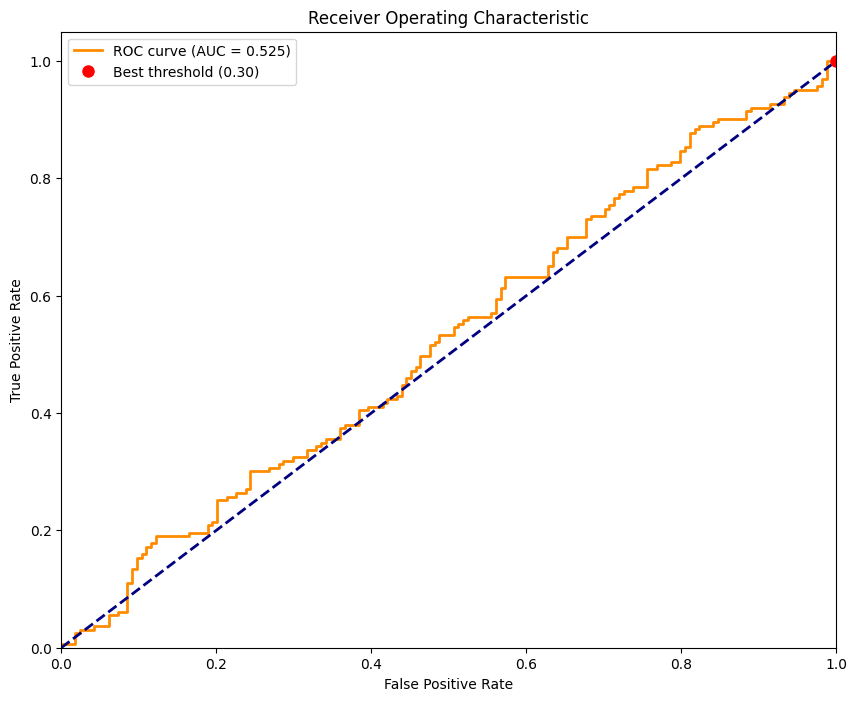

In [19]:
"""
ECG-based Chagas Disease Detection using Balanced Learning Approach
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports for metrics and evaluation
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, 
    confusion_matrix, roc_curve, auc
)

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

#########################
# DATA PREPROCESSING
#########################

def preprocess_ecg(X, downsample_factor=8, normalize=True):
    """
    Simple but robust preprocessing for ECG signals
    """
    # Downsample to reduce computation
    X_down = X[:, ::downsample_factor, :]
    
    # Normalize each signal to have zero mean and unit variance
    if normalize:
        for i in range(X_down.shape[0]):
            for j in range(X_down.shape[2]):
                mean = np.mean(X_down[i, :, j])
                std = np.std(X_down[i, :, j])
                if std > 0:
                    X_down[i, :, j] = (X_down[i, :, j] - mean) / std
    
    return X_down

#########################
# MODEL ARCHITECTURE
#########################

class SimpleECGModel(nn.Module):
    """
    Simplified 1D CNN model for ECG classification with balanced learning
    """
    def __init__(self, input_channels=12, dropout_rate=0.5):
        super(SimpleECGModel, self).__init__()
        
        # Use fixed architecture with moderate capacity
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=4)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=4)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layer with L2 regularization applied in optimizer
        self.fc = nn.Linear(64, 1)
        
        # Initialize weights very carefully
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                # Initialize with small weights
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                # Initialize with small weights for the final layer
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        # Format for Conv1d 
        x = x.permute(0, 2, 1)
        
        # First conv block with strong regularization
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second conv block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Global pooling
        x = self.global_pool(x).squeeze(-1)
        
        # Linear layer (no activation - use with BCEWithLogitsLoss)
        x = self.fc(x)
        
        return x

#########################
# VISUALIZATION FUNCTIONS
#########################

def plot_confusion_matrix(conf_matrix, threshold):
    """
    Plot a detailed confusion matrix visualization
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix (threshold={threshold:.2f})')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_thresh_{threshold:.2f}.png')
    plt.close()

#########################
# TRAINING & EVALUATION
#########################

def train_simple_model(model, X_train, y_train, X_val, y_val, lr=0.0001, 
                      batch_size=32, epochs=15, weight_decay=0.001):
    """
    Train a model with balanced batches and careful monitoring of class-wise performance
    
    Parameters:
    -----------
    model : torch.nn.Module
        The model to train
    X_train, y_train : numpy.ndarray
        Training data and labels
    X_val, y_val : numpy.ndarray
        Validation data and labels
    lr : float
        Learning rate
    batch_size : int
        Batch size
    epochs : int
        Number of training epochs
    weight_decay : float
        L2 regularization strength
        
    Returns:
    --------
    model : torch.nn.Module
        Trained model
    best_val_acc : float
        Best validation balanced accuracy
    """
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
    
    # Create separate datasets for positive and negative examples
    pos_indices = np.where(y_train == 1)[0]
    neg_indices = np.where(y_train == 0)[0]
    
    print(f"Training set: {len(pos_indices)} positive, {len(neg_indices)} negative")
    
    # Use weighted random sampler to ensure balanced batches
    if len(pos_indices) != len(neg_indices):
        # Compute class weights inversely proportional to class frequencies
        pos_weight = 1.0 / len(pos_indices)
        neg_weight = 1.0 / len(neg_indices)
        
        # Create sample weights array
        weights = torch.zeros(len(y_train))
        weights[pos_indices] = pos_weight
        weights[neg_indices] = neg_weight
        
        # Create weighted sampler
        sampler = WeightedRandomSampler(
            weights=weights,
            num_samples=batch_size * (len(X_train) // batch_size),
            replacement=True
        )
        
        # Create DataLoader with the sampler
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, sampler=sampler
        )
    else:
        # If balanced, just shuffle
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True
        )
    
    # Validation loader
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Loss function
    criterion = nn.BCEWithLogitsLoss()
    
    # Training loop
    best_val_acc = 0
    best_model_state = None
    
    # For tracking training progress
    train_losses = []
    train_accs = []
    val_accs = []
    val_balanced_accs = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        train_pos_correct = 0
        train_neg_correct = 0
        train_pos_total = 0
        train_neg_total = 0
        
        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track statistics
            train_loss += loss.item()
            
            # Calculate accuracy
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
            
            # Track class-wise accuracy
            train_pos_correct += ((predicted == 1) & (labels == 1)).sum().item()
            train_neg_correct += ((predicted == 0) & (labels == 0)).sum().item()
            train_pos_total += (labels == 1).sum().item()
            train_neg_total += (labels == 0).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_pos_correct = 0
        val_neg_correct = 0
        val_pos_total = 0
        val_neg_total = 0
        all_val_outputs = []
        all_val_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                all_val_outputs.extend(outputs.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
                
                # Calculate accuracy
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
                
                # Track class-wise accuracy
                val_pos_correct += ((predicted == 1) & (labels == 1)).sum().item()
                val_neg_correct += ((predicted == 0) & (labels == 0)).sum().item()
                val_pos_total += (labels == 1).sum().item()
                val_neg_total += (labels == 0).sum().item()
        
        # Calculate metrics
        train_acc = train_correct / train_total if train_total > 0 else 0
        train_pos_acc = train_pos_correct / train_pos_total if train_pos_total > 0 else 0
        train_neg_acc = train_neg_correct / train_neg_total if train_neg_total > 0 else 0
        
        val_acc = val_correct / val_total if val_total > 0 else 0
        val_pos_acc = val_pos_correct / val_pos_total if val_pos_total > 0 else 0
        val_neg_acc = val_neg_correct / val_neg_total if val_neg_total > 0 else 0
        
        # Track metrics for plotting
        train_losses.append(train_loss / len(train_loader))
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Calculate balanced accuracy (average of class-wise accuracies)
        val_balanced_acc = (val_pos_acc + val_neg_acc) / 2
        val_balanced_accs.append(val_balanced_acc)
        
        # Print progress - include class-wise accuracy
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train: loss={train_loss/len(train_loader):.4f}, acc={train_acc:.4f} " + 
              f"(pos={train_pos_acc:.4f}, neg={train_neg_acc:.4f})")
        print(f"Val: loss={val_loss/len(val_loader):.4f}, acc={val_acc:.4f} " + 
              f"(pos={val_pos_acc:.4f}, neg={val_neg_acc:.4f})")
        
        # Save best model (using balanced accuracy)
        if val_balanced_acc > best_val_acc:
            best_val_acc = val_balanced_acc
            best_model_state = model.state_dict().copy()
            print(f"New best model! Balanced accuracy: {val_balanced_acc:.4f}")
        
        # Plot and save confusion matrix for this epoch
        all_val_probs = 1 / (1 + np.exp(-np.array(all_val_outputs).flatten()))
        all_val_preds = (all_val_probs > 0.5).astype(float)
        all_val_labels = np.array(all_val_labels).flatten()
        conf_mat = confusion_matrix(all_val_labels, all_val_preds)
        
        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == epochs - 1:  # Plot every 5 epochs and first/last epoch
            plot_confusion_matrix(conf_mat, threshold=0.5)
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Plot training progress
    plt.figure(figsize=(15, 5))
    
    # Plot training loss
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # Plot training and validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot balanced validation accuracy
    plt.subplot(1, 3, 3)
    plt.plot(val_balanced_accs)
    plt.title('Balanced Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Balanced Accuracy')
    
    plt.tight_layout()
    plt.savefig('training_progress.png')
    plt.close()
    
    return model, best_val_acc

#########################
# MAIN SCRIPT EXECUTION
#########################

if __name__ == "__main__":
    # Preprocess data
    print("Preprocessing ECG data...")
    X_train_processed = preprocess_ecg(X_train, downsample_factor=8, normalize=True)
    X_test_processed = preprocess_ecg(X_test, downsample_factor=8, normalize=True)

    print(f"Processed data shape: {X_train_processed.shape}")

    # Create and train model
    print("\nTraining a balanced model...")
    model = SimpleECGModel(input_channels=X_train_processed.shape[2], dropout_rate=0.5)
    model, _ = train_simple_model(
        model, 
        X_train_processed, y_train, 
        X_test_processed, y_test,
        lr=0.0001,  # Low learning rate
        batch_size=32,
        epochs=20,
        weight_decay=0.001  # Stronger regularization
    )

    # Save the model
    torch.save(model.state_dict(), 'balanced_ecg_model.pth')

    # Evaluate the model
    print("\nEvaluating the model...")
    model.eval()
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32)

    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            all_outputs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_outputs = np.array(all_outputs).flatten()
    all_labels = np.array(all_labels).flatten()
    all_probs = 1 / (1 + np.exp(-all_outputs))  # Convert logits to probabilities

    # Try different thresholds and print results for each
    thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
    print("\nTesting different classification thresholds:")

    best_f1 = 0
    best_threshold = 0.5
    best_conf_matrix = None
    best_metrics = None

    # Create a figure for all confusion matrices
    plt.figure(figsize=(15, 10))
    
    for i, threshold in enumerate(thresholds):
        all_preds = (all_probs > threshold).astype(float)
        conf_matrix = confusion_matrix(all_labels, all_preds)
        tn, fp, fn, tp = conf_matrix.ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
        balanced_acc = (sensitivity + specificity) / 2
        
        print(f"\nThreshold: {threshold}")
        print(f"Confusion Matrix:\n{conf_matrix}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Balanced Accuracy: {balanced_acc:.4f}")
        print(f"Sensitivity/Recall: {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Plot confusion matrix for this threshold
        plt.subplot(2, 3, i+1)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        plt.title(f'Threshold = {threshold:.1f}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        
        # Track the best threshold based on F1 score
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_conf_matrix = conf_matrix
            best_metrics = {
                'accuracy': accuracy,
                'balanced_acc': balanced_acc,
                'sensitivity': sensitivity,
                'specificity': specificity,
                'precision': precision,
                'f1': f1
            }

    plt.tight_layout()
    plt.savefig('confusion_matrices_all_thresholds.png')
    plt.close()

    # Use the best threshold for final evaluation
    print(f"\nBest threshold: {best_threshold} with F1 Score: {best_f1:.4f}")
    all_preds = (all_probs > best_threshold).astype(float)

    # Plot detailed confusion matrix for the best threshold
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['Negative', 'Positive'],
               yticklabels=['Negative', 'Positive'])
    
    # Add performance metrics to the plot
    plt.title(f'Confusion Matrix (Best Threshold = {best_threshold:.2f})')
    
    # Add text box with performance metrics
    metrics_text = "\n".join([
        f"Accuracy: {best_metrics['accuracy']:.4f}",
        f"Balanced Accuracy: {best_metrics['balanced_acc']:.4f}",
        f"Sensitivity: {best_metrics['sensitivity']:.4f}",
        f"Specificity: {best_metrics['specificity']:.4f}",
        f"Precision: {best_metrics['precision']:.4f}", 
        f"F1 Score: {best_metrics['f1']:.4f}"
    ])
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(1.05, 0.5, metrics_text, transform=plt.gca().transAxes, 
            fontsize=10, verticalalignment='center', bbox=props)
    
    plt.tight_layout()
    plt.savefig('best_confusion_matrix.png')
    plt.close()

    # Print final evaluation results
    print("\nFinal Model Evaluation:")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    print("\nConfusion Matrix:")
    print(best_conf_matrix)

    print(f"\nFinal Metrics:")
    print(f"Accuracy: {best_metrics['accuracy']:.4f}")
    print(f"Balanced Accuracy: {best_metrics['balanced_acc']:.4f}")
    print(f"Sensitivity/Recall: {best_metrics['sensitivity']:.4f}")
    print(f"Specificity: {best_metrics['specificity']:.4f}")
    print(f"Precision: {best_metrics['precision']:.4f}")
    print(f"F1 Score: {best_metrics['f1']:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    # Mark the best threshold on the ROC curve
    threshold_idx = np.argmin(np.abs(fpr - (1-best_metrics['specificity'])))
    plt.plot([fpr[threshold_idx]], [tpr[threshold_idx]], 'ro', markersize=8, 
             label=f'Best threshold ({best_threshold:.2f})')
    plt.legend()
    
    plt.savefig('balanced_model_roc.png')

### Grid Search CV

Preprocessing ECG data...
Processed data shape: (1304, 512, 12)

Performing grid search with cross-validation...

Evaluating parameters 1/27: {'lr': 0.0001, 'dropout_rate': 0.3, 'weight_decay': 0.0001}
  Fold 1/3
Training set: 434 positive, 435 negative
Epoch 1/10
Train: loss=0.6932, acc=0.5023 (pos=0.9977, neg=0.0000)
Val: loss=0.6932, acc=0.5011 (pos=1.0000, neg=0.0000)
New best model! Balanced accuracy: 0.5000
Epoch 2/10
Train: loss=0.6934, acc=0.4954 (pos=0.9696, neg=0.0298)
Val: loss=0.6930, acc=0.4966 (pos=0.9862, neg=0.0046)
Epoch 3/10
Train: loss=0.6926, acc=0.5150 (pos=0.9797, neg=0.0261)
Val: loss=0.6930, acc=0.4989 (pos=0.9862, neg=0.0092)
Epoch 4/10
Train: loss=0.6936, acc=0.5046 (pos=0.9698, neg=0.0438)
Val: loss=0.6929, acc=0.4989 (pos=0.9862, neg=0.0092)
Epoch 5/10
Train: loss=0.6926, acc=0.5139 (pos=0.8378, neg=0.1714)
Val: loss=0.6929, acc=0.4966 (pos=0.9771, neg=0.0138)
Epoch 6/10
Train: loss=0.6930, acc=0.5093 (pos=0.9391, neg=0.0892)
Val: loss=0.6929, acc=0.5057 (po

C:\Users\rjhha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rjhha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rjhha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati


Comparing optimized model with baseline:
1. Training a baseline model with default parameters...
Training set: 652 positive, 652 negative
Epoch 1/20
Train: loss=0.6937, acc=0.4962 (pos=0.0138, neg=0.9785)
Val: loss=0.6929, acc=0.5168 (pos=0.2331, neg=0.7988)
New best model! Balanced accuracy: 0.5160
Epoch 2/20
Train: loss=0.6931, acc=0.5084 (pos=0.0675, neg=0.9494)
Val: loss=0.6929, acc=0.5321 (pos=0.3497, neg=0.7134)
New best model! Balanced accuracy: 0.5316
Epoch 3/20
Train: loss=0.6932, acc=0.5077 (pos=0.2653, neg=0.7500)
Val: loss=0.6928, acc=0.5291 (pos=0.5644, neg=0.4939)
Epoch 4/20
Train: loss=0.6932, acc=0.5115 (pos=0.4080, neg=0.6150)
Val: loss=0.6928, acc=0.5107 (pos=0.5890, neg=0.4329)
Epoch 5/20
Train: loss=0.6929, acc=0.5015 (pos=0.3988, neg=0.6043)
Val: loss=0.6928, acc=0.5321 (pos=0.6871, neg=0.3780)
New best model! Balanced accuracy: 0.5326
Epoch 6/20
Train: loss=0.6934, acc=0.4916 (pos=0.5107, neg=0.4724)
Val: loss=0.6927, acc=0.5138 (pos=0.6871, neg=0.3415)
Epoch 7/2

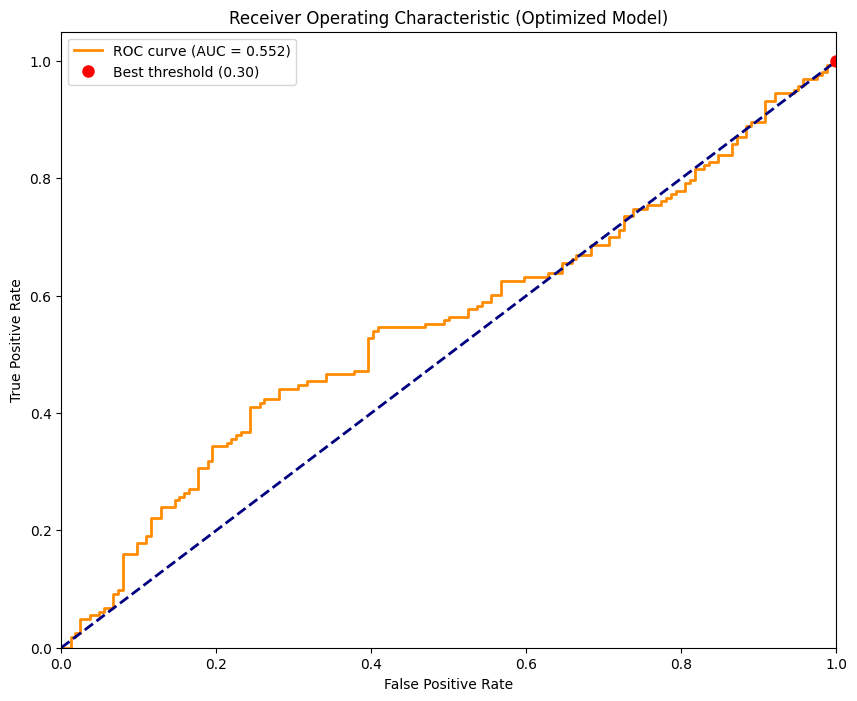

In [ ]:
def grid_search_cv(X, y, model_class, param_grid, n_folds=5, batch_size=32, epochs=10):
    """
    Perform grid search with cross-validation for ECG model hyperparameters.
    
    Parameters:
    -----------
    X : numpy.ndarray
        Feature data
    y : numpy.ndarray
        Target labels
    model_class : class
        Model class to be instantiated with different parameters
    param_grid : dict
        Dictionary with parameter names as keys and lists of parameter values
    n_folds : int
        Number of folds for cross-validation
    batch_size : int
        Batch size for training
    epochs : int
        Number of epochs for each training run
        
    Returns:
    --------
    best_params : dict
        Best parameters found
    best_score : float
        Best balanced accuracy score achieved
    results : list
        List of dictionaries containing all results
    """
       
    # Create all possible parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(itertools.product(*(param_grid[name] for name in param_names)))
    
    # Initialize results tracking
    best_score = 0
    best_params = None
    results = []
    
    # Set up stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Start timer
    start_time = time.time()
    
    # Iterate through all parameter combinations
    for i, values in enumerate(param_values):
        params = dict(zip(param_names, values))
        print(f"\nEvaluating parameters {i+1}/{len(param_values)}: {params}")
        
        # Track scores across folds
        fold_scores = []
        
        # Perform k-fold cross-validation
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            print(f"  Fold {fold+1}/{n_folds}")
            
            # Split data
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            
            # Create and initialize model with current parameters
            if 'dropout_rate' in params:
                model = model_class(input_channels=X.shape[2], dropout_rate=params['dropout_rate'])
            else:
                model = model_class(input_channels=X.shape[2])
            
            # Extract training parameters
            train_params = {k: v for k, v in params.items() 
                           if k in ['lr', 'weight_decay']}
            
            # Train model with current parameters
            fold_model, fold_score = train_simple_model(
                model,
                X_train_fold, y_train_fold,
                X_val_fold, y_val_fold,
                batch_size=batch_size,
                epochs=epochs,
                **train_params
            )
            
            fold_scores.append(fold_score)
            
            # Freeing up GPU memory
            del fold_model
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        # Calculate average score across folds
        mean_score = np.mean(fold_scores)
        std_score = np.std(fold_scores)
        
        # Track results
        result = {
            'params': params,
            'mean_balanced_acc': mean_score,
            'std_balanced_acc': std_score,
            'fold_scores': fold_scores
        }
        results.append(result)
        
        print(f"  Mean balanced accuracy: {mean_score:.4f} ± {std_score:.4f}")
        
        # Update best parameters if better score achieved
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
            print(f"  New best parameters found!")
    
    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    print(f"\nGrid search completed in {elapsed_time:.2f} seconds")
    print(f"Best parameters: {best_params}")
    print(f"Best balanced accuracy: {best_score:.4f}")
    
    # Sort results by score
    results.sort(key=lambda x: x['mean_balanced_acc'], reverse=True)
    
    return best_params, best_score, results


if __name__ == "__main__":
    # Defining parameter grid
    param_grid = {
        'lr': [0.0001, 0.0005, 0.001],
        'dropout_rate': [0.3, 0.5, 0.7],
        'weight_decay': [0.0001, 0.001, 0.01]
    }
    
    # Preprocess data
    print("Preprocessing ECG data...")
    X_train_processed = preprocess_ecg(X_train, downsample_factor=8, normalize=True)
    X_test_processed = preprocess_ecg(X_test, downsample_factor=8, normalize=True)
    
    print(f"Processed data shape: {X_train_processed.shape}")
    
    # Perform grid search
    print("\nPerforming grid search with cross-validation...")
    best_params, best_score, all_results = grid_search_cv(
        X_train_processed, y_train,
        SimpleECGModel,
        param_grid,
        n_folds=3,  # Using 3 folds for faster execution
        batch_size=32,
        epochs=10   # Reduced number of epochs for faster search
    )
    
    # Plot grid search results
    print("\nPlotting grid search results...")
    plt.figure(figsize=(15, 10))
    
    # Plot learning rate vs score
    lr_values = sorted(set([r['params']['lr'] for r in all_results]))
    lr_scores = [np.mean([r['mean_balanced_acc'] for r in all_results if r['params']['lr'] == lr]) for lr in lr_values]
    
    plt.subplot(2, 2, 1)
    plt.plot(lr_values, lr_scores, 'o-')
    plt.xlabel('Learning Rate')
    plt.ylabel('Mean Balanced Accuracy')
    plt.title('Effect of Learning Rate')
    
    # Plot dropout rate vs score
    dropout_values = sorted(set([r['params']['dropout_rate'] for r in all_results]))
    dropout_scores = [np.mean([r['mean_balanced_acc'] for r in all_results if r['params']['dropout_rate'] == d]) for d in dropout_values]
    
    plt.subplot(2, 2, 2)
    plt.plot(dropout_values, dropout_scores, 'o-')
    plt.xlabel('Dropout Rate')
    plt.ylabel('Mean Balanced Accuracy')
    plt.title('Effect of Dropout Rate')
    
    # Plot weight decay vs score
    wd_values = sorted(set([r['params']['weight_decay'] for r in all_results]))
    wd_scores = [np.mean([r['mean_balanced_acc'] for r in all_results if r['params']['weight_decay'] == wd]) for wd in wd_values]
    
    plt.subplot(2, 2, 3)
    plt.plot(wd_values, wd_scores, 'o-')
    plt.xlabel('Weight Decay')
    plt.ylabel('Mean Balanced Accuracy')
    plt.title('Effect of Weight Decay')
    
    # Plot top results
    top_results = sorted(all_results, key=lambda x: x['mean_balanced_acc'], reverse=True)[:10]
    
    plt.subplot(2, 2, 4)
    result_names = [f"Run {i+1}" for i in range(len(top_results))]
    result_scores = [r['mean_balanced_acc'] for r in top_results]
    result_errors = [r['std_balanced_acc'] for r in top_results]
    
    plt.bar(result_names, result_scores, yerr=result_errors)
    plt.xlabel('Run')
    plt.ylabel('Mean Balanced Accuracy')
    plt.title('Top 10 Parameter Combinations')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('grid_search_results.png')
    plt.close()
    
    # Create and train final model with best parameters
    print("\nTraining final model with best parameters...")
    final_model = SimpleECGModel(input_channels=X_train_processed.shape[2], dropout_rate=best_params['dropout_rate'])
    final_model, _ = train_simple_model(
        final_model, 
        X_train_processed, y_train, 
        X_test_processed, y_test,
        lr=best_params['lr'],
        batch_size=32,
        epochs=20,
        weight_decay=best_params['weight_decay']
    )
    
    # Save the model
    torch.save(final_model.state_dict(), 'optimized_ecg_model.pth')
    
    # Evaluate the final model
    print("\nEvaluating the optimized model...")
    final_model.eval()
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32)

    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = final_model(inputs)
            all_outputs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_outputs = np.array(all_outputs).flatten()
    all_labels = np.array(all_labels).flatten()
    all_probs = 1 / (1 + np.exp(-all_outputs))  # Convert logits to probabilities

    # Try different thresholds and print results for each
    thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
    print("\nTesting different classification thresholds:")

    best_f1 = 0
    best_threshold = 0.5
    best_conf_matrix = None
    best_metrics = None

    # Create a figure for all confusion matrices
    plt.figure(figsize=(15, 10))
    
    for i, threshold in enumerate(thresholds):
        all_preds = (all_probs > threshold).astype(float)
        conf_matrix = confusion_matrix(all_labels, all_preds)
        tn, fp, fn, tp = conf_matrix.ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
        balanced_acc = (sensitivity + specificity) / 2
        
        print(f"\nThreshold: {threshold}")
        print(f"Confusion Matrix:\n{conf_matrix}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Balanced Accuracy: {balanced_acc:.4f}")
        print(f"Sensitivity/Recall: {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Plot confusion matrix for this threshold
        plt.subplot(2, 3, i+1)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        plt.title(f'Threshold = {threshold:.1f} (Optimized Model)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        
        # Track the best threshold based on F1 score
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_conf_matrix = conf_matrix
            best_metrics = {
                'accuracy': accuracy,
                'balanced_acc': balanced_acc,
                'sensitivity': sensitivity,
                'specificity': specificity,
                'precision': precision,
                'f1': f1
            }

    plt.tight_layout()
    plt.savefig('optimized_model_confusion_matrices.png')
    plt.close()

    # Use the best threshold for final evaluation
    print(f"\nBest threshold: {best_threshold} with F1 Score: {best_f1:.4f}")
    all_preds = (all_probs > best_threshold).astype(float)

    # Plot detailed confusion matrix for the best threshold
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['Negative', 'Positive'],
               yticklabels=['Negative', 'Positive'])
    
    # Add performance metrics to the plot
    plt.title(f'Confusion Matrix (Optimized Model, Best Threshold = {best_threshold:.2f})')
    
    # Add text box with performance metrics
    metrics_text = "\n".join([
        f"Accuracy: {best_metrics['accuracy']:.4f}",
        f"Balanced Accuracy: {best_metrics['balanced_acc']:.4f}",
        f"Sensitivity: {best_metrics['sensitivity']:.4f}",
        f"Specificity: {best_metrics['specificity']:.4f}",
        f"Precision: {best_metrics['precision']:.4f}", 
        f"F1 Score: {best_metrics['f1']:.4f}"
    ])
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(1.05, 0.5, metrics_text, transform=plt.gca().transAxes, 
            fontsize=10, verticalalignment='center', bbox=props)
    
    plt.tight_layout()
    plt.savefig('optimized_model_best_confusion_matrix.png')
    plt.close()

    # Print final evaluation results
    print("\nFinal Optimized Model Evaluation:")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    print("\nConfusion Matrix:")
    print(best_conf_matrix)

    print(f"\nFinal Metrics:")
    print(f"Accuracy: {best_metrics['accuracy']:.4f}")
    print(f"Balanced Accuracy: {best_metrics['balanced_acc']:.4f}")
    print(f"Sensitivity/Recall: {best_metrics['sensitivity']:.4f}")
    print(f"Specificity: {best_metrics['specificity']:.4f}")
    print(f"Precision: {best_metrics['precision']:.4f}")
    print(f"F1 Score: {best_metrics['f1']:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Optimized Model)')
    plt.legend(loc="lower right")
    
    # Mark the best threshold on the ROC curve
    threshold_idx = np.argmin(np.abs(fpr - (1-best_metrics['specificity'])))
    plt.plot([fpr[threshold_idx]], [tpr[threshold_idx]], 'ro', markersize=8, 
             label=f'Best threshold ({best_threshold:.2f})')
    plt.legend()
    
    plt.savefig('optimized_model_roc.png')
    
    # Compare with baseline model (if available)
    print("\nComparing optimized model with baseline:")
    print("1. Training a baseline model with default parameters...")
    
    baseline_model = SimpleECGModel(input_channels=X_train_processed.shape[2], dropout_rate=0.5)
    baseline_model, _ = train_simple_model(
        baseline_model, 
        X_train_processed, y_train, 
        X_test_processed, y_test,
        lr=0.0001,
        batch_size=32,
        epochs=20,
        weight_decay=0.001
    )
    
    # Evaluate baseline model
    baseline_model.eval()
    baseline_outputs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = baseline_model(inputs)
            baseline_outputs.extend(outputs.cpu().numpy())
    
    baseline_outputs = np.array(baseline_outputs).flatten()
    baseline_probs = 1 / (1 + np.exp(-baseline_outputs))
    baseline_preds = (baseline_probs > 0.5).astype(float)
    
    baseline_conf_matrix = confusion_matrix(all_labels, baseline_preds)
    tn, fp, fn, tp = baseline_conf_matrix.ravel()
    baseline_accuracy = (tp + tn) / (tp + tn + fp + fn)
    baseline_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    baseline_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    baseline_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    baseline_f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    baseline_balanced_acc = (baseline_sensitivity + baseline_specificity) / 2
    
    # Plot comparison of ROC curves
    baseline_fpr, baseline_tpr, _ = roc_curve(all_labels, baseline_probs)
    baseline_auc = auc(baseline_fpr, baseline_tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'Optimized model ROC (AUC = {roc_auc:.3f})')
    plt.plot(baseline_fpr, baseline_tpr, color='green', lw=2, 
             label=f'Baseline model ROC (AUC = {baseline_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison: Optimized vs Baseline')
    plt.legend(loc="lower right")
    plt.savefig('roc_comparison.png')
    plt.close()
    
    # Print comparison metrics
    print("\nComparison of metrics:")
    print(f"{'Metric':<20} {'Baseline':<10} {'Optimized':<10} {'Improvement':<10}")
    print(f"{'-'*50}")
    print(f"{'Accuracy':<20} {baseline_accuracy:.4f} {best_metrics['accuracy']:.4f} {best_metrics['accuracy']-baseline_accuracy:.4f}")
    print(f"{'Balanced Accuracy':<20} {baseline_balanced_acc:.4f} {best_metrics['balanced_acc']:.4f} {best_metrics['balanced_acc']-baseline_balanced_acc:.4f}")
    print(f"{'Sensitivity':<20} {baseline_sensitivity:.4f} {best_metrics['sensitivity']:.4f} {best_metrics['sensitivity']-baseline_sensitivity:.4f}")
    print(f"{'Specificity':<20} {baseline_specificity:.4f} {best_metrics['specificity']:.4f} {best_metrics['specificity']-baseline_specificity:.4f}")
    print(f"{'F1 Score':<20} {baseline_f1:.4f} {best_metrics['f1']:.4f} {best_metrics['f1']-baseline_f1:.4f}")
    print(f"{'AUC':<20} {baseline_auc:.4f} {roc_auc:.4f} {roc_auc-baseline_auc:.4f}")
    
    # Save comparative confusion matrices
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(baseline_conf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Negative', 'Positive'],
               yticklabels=['Negative', 'Positive'])
    plt.title('Baseline Model')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Negative', 'Positive'],
               yticklabels=['Negative', 'Positive'])
    plt.title('Optimized Model')
    
    plt.tight_layout()
    plt.savefig('confusion_matrix_comparison.png')
    plt.close()
    
    print("\nAll evaluation completed. Results saved as image files.")